# Лабораторная работа №2

## Условие

Вариант №14

Распределения:

$$\mathbf{X} \sim R(0, 10)$$
$$\mathbf{Y} \sim N(5, 3)$$

Объёмы выборок:

$$ n_1 = 200$$
$$ n_2 = 250 $$

## Импорты

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from time import time
from IPython.display import display, Math, Markdown  # для вывода формул в консоль

## Определения

In [13]:
a1, b1, n1 = 0, 10, 200
a2, b2, n2 = 5, 3, 250

In [14]:
def mprint(*strings):
    for s in strings:
        display(Markdown(s))


np.random.seed(int(time()))
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage[english, russian]{babel}
\usepackage[utf8]{inputenc}
""",
)
plt.style.use("seaborn-v0_8")

In [15]:
alpha = 0.05


def verdict(alpha, p_value):
    if alpha > p_value:
        return "$H_0$ отклоняется"
    else:
        return "$H_0$ принимается"

## 1. Исходные данные

In [68]:
np.random.seed(42)
X = np.random.uniform(a1, b1, n1)
Y = np.random.normal(loc=5, scale=np.sqrt(3), size=n2)
mprint(f"$\\mathbf{{X}}$: {X[:10].round(2)}")

$\mathbf{X}$: [3.75 9.51 7.32 5.99 1.56 1.56 0.58 8.66 6.01 7.08]

### Выборочные характеристики

Мы имеем выборку, нам нужно рассчитать **несмещенную** оценку с.к.о. и дисперсии, поэтому применяем формулы:

$$ s = \sqrt{\dfrac{1}{n - 1} \sum\limits_{i = 1}^{n} (x_i - \overline{x})^2} $$
$$ s^2 = \dfrac{1}{n - 1} \sum\limits_{i = 1}^{n} (x_i - \overline{x})^2 $$

Множитель $\dfrac{1}{n - a}$  в `numpy` достигается передачей в данном случае `ddof=1`. 

In [24]:
mean1 = X.mean()
s1 = X.std(ddof=1)
S1 = X.var(ddof=1)

mprint(f"$\\overline{{x}} =$ {mean1:.2f}, $s^2 =$ {S1:.2f}, $s$ = {s1:.2f}")

$\overline{x} =$ 4.84, $s^2 =$ 8.70, $s$ = 2.95

## 2. Визуальное представление выборки

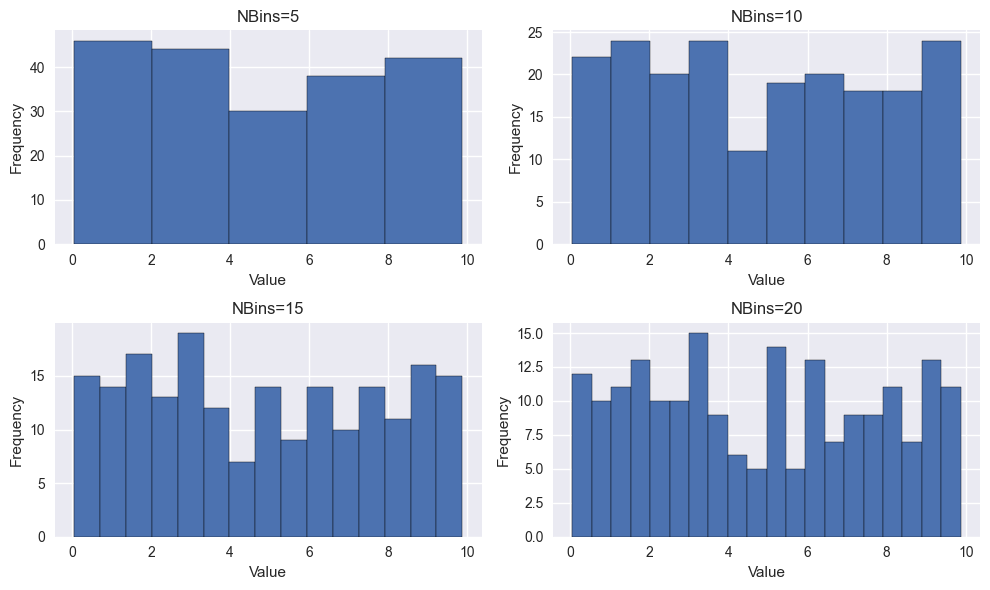

In [29]:
bins_list = [5, 10, 15, 20] #диапазон значений внутри которого мы считаем сколько наблюдений попало  
plt.rcParams.update({"text.usetex": False})
fig, axes = plt.subplots(2, 2, figsize=(10, 6))# сетка 2 на 2,размер всего полотна

for ax, NBins in zip(axes.flatten(), bins_list):
    ax.hist(X, bins=NBins, edgecolor="black")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{NBins=}")
plt.tight_layout()  # оптимизирует отступы
plt.show()

## 3. Критерий $\chi^2$

### Теоретия

Есть выборка объёма $n$: $x_1, x_2, \dots, x_n$ случайной величины $\mathbf X \sim F_X(x)$.

Мы хотим понять вид распределения случайной величины $\mathbf X$:
$$ H_0:\ F_X(x) = G(x) $$
$$ H_1:\ F_X(x) \neq G(x)  $$
где G(x) известная функция

Разбиваем выборку в группированный статистический ряд. Рекомендуется выбирать $\Delta_i$ так, чтобы $n \cdot p_i \gtrsim 5$ 

| $\Delta_i$ | $\Delta_1$ | $\cdots$ | $\Delta_k$ |
| ---------- | ---------- | -------- | ---------- |
| $n_i$      | $n_1$      | $\cdots$ | $n_k$      |

$n_i$ - частота попадания случайной величины $\mathbf X$ в интервал $\Delta_i$.

$p_i$ - вероятность попадания случайной величины $\mathbf X$ в интервал $\Delta_i$ в условиях $H_0$, то есть, если $\Delta_i = (a_{i-1}, a_{i}]$, то 

$$p_i = \int\limits_{a_{i-1}}^{a_{i}}g(x)dx = G(a_{i}) - G(a_{i-1})$$
$n_i$*$p_i$ - кол-во наблюдений в i столбце , если H0 верна

Статистика критерия: 
$$Z = \sum\limits_{i=1}^k \dfrac{(n_i - n \cdot p_i)^2}{n \cdot p_i}$$
$$Z \mid_{H_0} \sim \chi^2(k-r-1),$$
где $r$ - количество оцениваемых параметров распределения $G$. 
Например:

1. если $H_0:\ \mathbf X \sim N(5, 2)$, то $r = 0$
2. если $H_0:\ \mathbf X \sim N(?, 2)$, то $r = 1$
3. если $H_0:\ \mathbf X \sim N(?, ?)$, то $r = 2$

При каком-то неизвестном параметре переформулируем задачу как $H_0:\ \mathbf X \sim N(\overline x, s)$, то есть используем МП-оценки для рассчёта параметров.



### Статистическая гипотеза $H_0:\ X \sim N(m, \sigma)$

In [73]:

def chi2_gof_normal(X, bins, mu=None, std=None):
    n = len(X)
    r = 0
    
    if not std:
        std = X.std(ddof=1)
        r += 1
    if not mu:
        mu = X.mean()
        r += 1
        
    freq, bin_edges = np.histogram(X, bins=bins) # частота , диапазон границ значений внутри которого мы считаем число попаданий 
    k = len(freq)
    p_list = stats.norm.cdf(bin_edges[1:], loc=mu, scale=std) - stats.norm.cdf(bin_edges[:-1], loc=mu, scale=std)
    #теоретическая вероятность попасть в каждый бин , при допущении что распределение нормальное F(b)-F(a)=P(a<=X<=b)
    
    z = sum((freq - n * p_list) ** 2 / (n * p_list)) #статистика
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [120]:
mprint(r"### $\chi^2$  test", f"$H_0: \\mathbf X \\sim N(5,3)$")
for bins in bins_list:
    z, p_value = chi2_gof_normal(X, bins)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$  test

$H_0: \mathbf X \sim N(5,3)$

#### NBins = 5

$z_{выб} =$ 54.79

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 75.53

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 15

$z_{выб} =$ 92.37

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 20

$z_{выб} =$ 93.12

$p =$ 0.00

$H_0$ отклоняется

### Статистическая гипотеза $H_0:\ X \sim R$

In [75]:
def chi2_gof_uniform(X, bins, a=None, b=None):
    n = len(X)
    r = 0
    if not a:
        a = X.min()
        r += 1
    if not b:
        b = X.max()
        r += 1
    frequences, bin_edges = np.histogram(X, bins=bins)
    k = len(frequences)
    p_list = stats.uniform.cdf(bin_edges[1:], loc=a, scale=b - a) - stats.uniform.cdf(
        bin_edges[:-1], loc=a, scale=b - a
    )
    z = sum((frequences - n * p_list) ** 2 / (n * p_list))
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [122]:
mprint(r"### $\chi^2$ goodness of fit test", f"$H_0: \\mathbf X \\sim R$")
for bins in bins_list:
    z, p_value = chi2_gof_uniform(X, bins)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$ goodness of fit test

$H_0: \mathbf X \sim R$

#### NBins = 5

$z_{выб} =$ 7.70

$p =$ 0.02

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 9.40

$p =$ 0.23

$H_0$ принимается

#### NBins = 15

$z_{выб} =$ 14.65

$p =$ 0.26

$H_0$ принимается

#### NBins = 20

$z_{выб} =$ 14.80

$p =$ 0.61

$H_0$ принимается

### Статистическая гипотеза $H_0:\ X \sim \chi^2(5)$

In [ ]:
def chi2_gof_chi2(X, bins, df=None):
    n = len(X)
    r = 0
    if not df:
        df = stats.chi2.fit(X)[0]
        r += 1
    frequences, bin_edges = np.histogram(X, bins=bins)
    k = len(frequences)
    p_list = stats.chi2.cdf(bin_edges[1:], df=df) - stats.chi2.cdf(
        bin_edges[:-1], df=df
    )
    z = sum((frequences - n * p_list) ** 2 / (n * p_list))
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [79]:
mprint(r"### $\chi^2$ goodness of fit test", f"$H_0: \\mathbf X \\sim \\chi^2(5)$")
for bins in bins_list:
    z, p_value = chi2_gof_chi2(X, bins,df=5)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$ goodness of fit test

$H_0: \mathbf X \sim \chi^2(5)$

#### NBins = 5

$z_{выб} =$ 59.81

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 89.39

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 15

$z_{выб} =$ 106.28

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 20

$z_{выб} =$ 126.77

$p =$ 0.00

$H_0$ отклоняется

## 4. Критерий Колмогорова

In [123]:
mprint(r"### ks-test")

z, p_value = stats.kstest(X, stats.norm.cdf, args=(X.mean(), X.std(ddof=1)))
mprint(
    f"$H_0: \\mathbf X \\sim N(m, std)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)


z, p_value = stats.kstest(X, stats.uniform.cdf, args=(X.min(), X.max() - X.min()))
mprint(
    f"$H_0: \\mathbf X \\sim R$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

z, p_value = stats.kstest(X, stats.chi2.cdf, args=(5,))
mprint(
    f"$H_0: \\mathbf X \\sim \\chi^2(5)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### ks-test

$H_0: \mathbf X \sim N(m, std)$

$z_{выб} =$ 0.08

$p =$ 0.11

$H_0$ принимается

$H_0: \mathbf X \sim R$

$z_{выб} =$ 0.08

$p =$ 0.13

$H_0$ принимается

$H_0: \mathbf X \sim \chi^2(5)$

$z_{выб} =$ 0.16

$p =$ 0.00

$H_0$ отклоняется

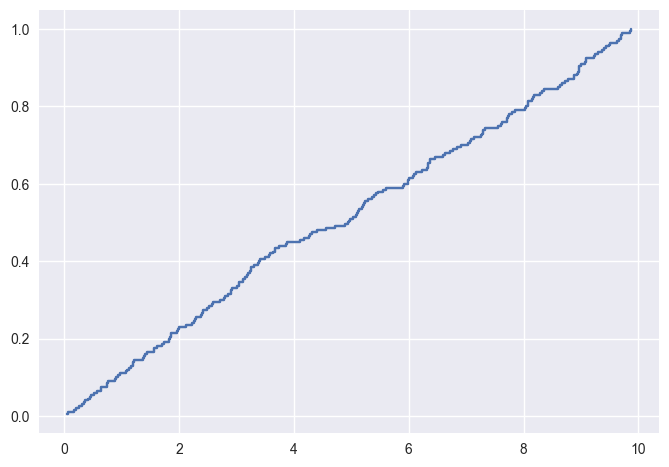

In [82]:
# сначала построим график  по выборке

n = len(X)
X_sorted = np.sort(X)
F = np.arange(1, n + 1) / n

plt.step(X_sorted, F, where="post")
plt.show()

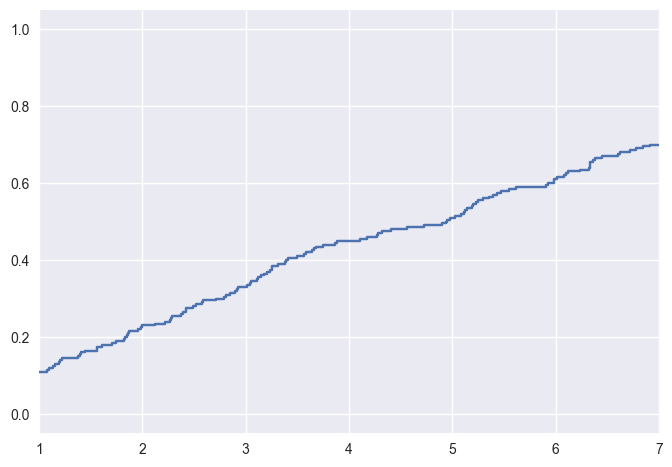

In [83]:
# теперь построим с "хвостиками"
X_sorted = np.concatenate(([-10000], X_sorted, [10000]))
F = np.concatenate(([0], F, [1]))

plt.step(X_sorted, F, where="post")
plt.xlim(1, 7)
plt.show()

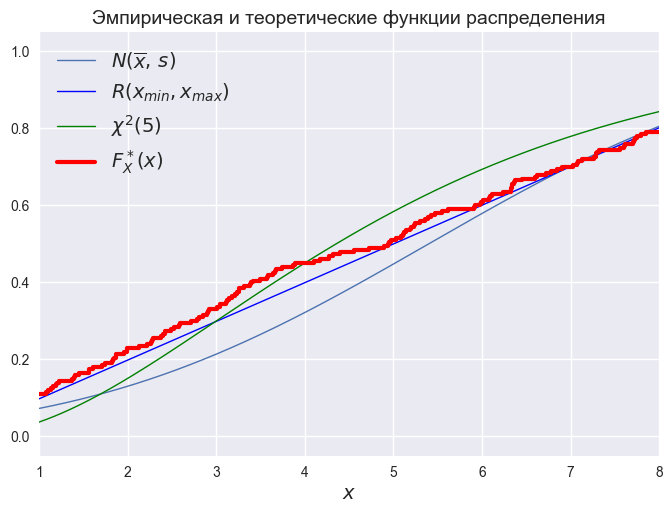

In [124]:
x = np.linspace(0, 10, 10000)
norm = stats.norm.cdf(x, loc=X.mean(), scale=X.std(ddof=1))
uniform = stats.uniform.cdf(x, loc=X.min(), scale=X.max() - X.min())
chi2 = stats.chi2.cdf(x, df=5)

plt.plot(x, norm, linewidth=1, label=r"$N(\overline{x},\, s)$")
# или короче
# plt.plot(x, norm, linewidth=1, label=r"$N(\bar{x},\, s)$")

plt.plot(x, uniform, color="b", linewidth=1, label=r"$R(x_{min}, x_{max})$")
plt.plot(x, chi2, color="g", linewidth=1, label=r"$\chi^2(5)$")
plt.step(X_sorted, F, where="post", color="r", linewidth=3, label=r"$F^*_X(x)$")

plt.title("Эмпирическая и теоретические функции распределения", fontsize=14)
plt.xlim(1, 8)
plt.legend(fontsize=14)
plt.xlabel("$x$", fontsize=14)

plt.show()






## 5. Двухвыборочные характеристики

In [125]:
Y = np.random.normal(loc=5, scale=np.sqrt(3), size=n2)
mprint(f"$\\mathbf{{Y}}$: {Y[:10].round(2)}")

$\mathbf{Y}$: [6.51 7.35 5.72 8.25 3.66 2.84 1.92 7.59 6.13 4.9 ]

### Графики

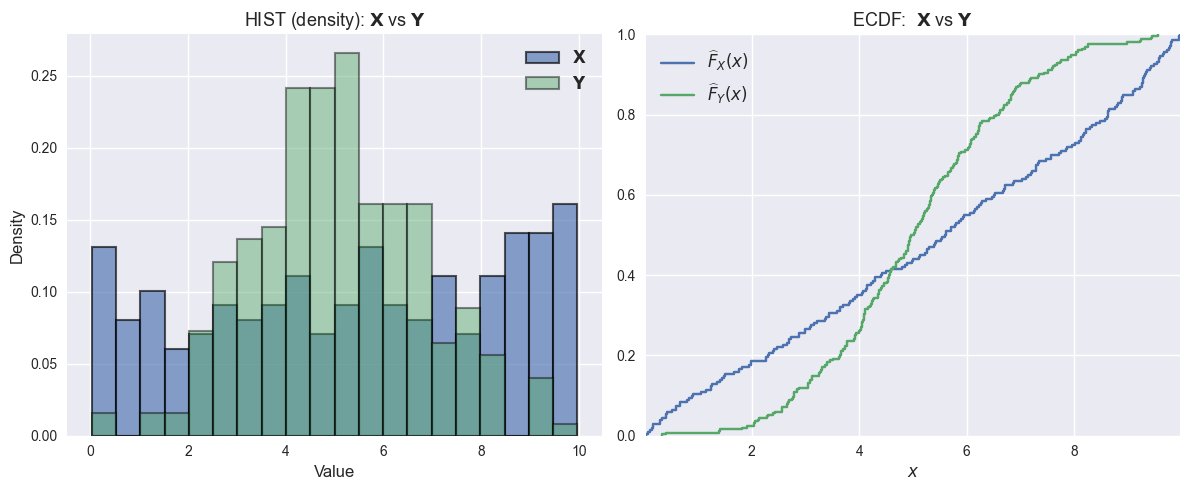

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# --- общий диапазон и бины ---
lo = min(X.min(), Y.min())
hi = max(X.max(), Y.max())
edges = np.linspace(lo, hi, 21)  # 20 бинов

# если по заданию нужно именно (0,10), раскомментируйте:
# edges = np.linspace(0, 10, 21)

# --- гистограммы (плотности) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X, bins=edges, density=True, alpha=0.65,
         edgecolor="black", linewidth=1.5, label=r"$\mathbf{X}$")
plt.hist(Y, bins=edges, density=True, alpha=0.45,
         edgecolor="black", linewidth=1.5, label=r"$\mathbf{Y}$")
plt.legend(fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title(r"HIST (density): $\mathbf{X}$ vs $\mathbf{Y}$", fontsize=13)

# --- ECDF (эмпирическая CDF) ---
def ecdf(a):
    a = np.sort(np.asarray(a))
    n = a.size
    # «хвосты» ровно на границах данных (без ±10000)
    x = np.concatenate(([a[0] - 1e-12], a, [a[-1] + 1e-12]))
    F = np.concatenate(([0.0], np.arange(1, n + 1) / n, [1.0]))
    return x, F

xs, Fx = ecdf(X)
ys, Fy = ecdf(Y)

plt.subplot(1, 2, 2)
plt.step(xs, Fx, where="post", label=r"$\widehat F_X(x)$")
plt.step(ys, Fy, where="post", label=r"$\widehat F_Y(x)$")
plt.xlim(lo, hi)
plt.ylim(0, 1)
plt.xlabel(r"$x$", fontsize=12)
plt.title(r"ECDF:  $\mathbf{X}$ vs $\mathbf{Y}$", fontsize=13)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


### Проверка гипотез об однородности 
### Двухвыборочный критерий $\chi^2$

У нас есть две выборки объёмов $n$ и $m$: 
$$x_1, x_2, \dots, x_n \text{- случайной величины } \mathbf X \sim F_X(x)$$
$$y_1, y_2, \dots, y_m \text{- случайной величины } \mathbf Y \sim F_Y(x)$$

Мы хотим понять, получены ли они из одной генеральной совокупности:
$$ H_0:\ F_X(x) = F_Y(x) $$
$$ H_1:\ F_X(x) \neq F_Y(x)  $$

Идея та же, что и у одновыборочного критерия $\chi^2$: cтроятся две гистограммы и сравниваются их высоты. Рекомендуется брать $\Delta_i$ так, чтобы $n_i + m_i \gtrsim 5$.

|интервал    | $\Delta_1$ | $\cdots$ | $\Delta_k$ |
| ---------- | ---------- | -------- | ---------- |
| $n_i$      | $n_1$      | $\cdots$ | $n_k$      |
| $m_i$      | $m_1$      | $\cdots$ | $m_k$      |

Статистика критерия: 
$$Z = nm \cdot \sum\limits_{i=1}^k \dfrac{1}{n_i + m_i}\left( \dfrac{n_i}{n} - \dfrac{m_i}{m} \right)^2$$
$$Z \mid_{H_0} \sim \chi^2(k-1)$$

### Критерий Chi-squared

In [ ]:
def chi2_gof(X, Y, bins):
    n = len(X)
    m = len(Y)
    frequencesX, bin_edges = np.histogram(
        X, bins=bins, range=(min(min(X), min(Y)), max(max(X), max(Y)))
    )
    # ni = frequencesX ; n 
    frequencesY, bin_edges = np.histogram(Y, bins=bin_edges) # mi = frequencesY ; m 
    z = (n* m* sum((frequencesX / n - frequencesY / m) ** 2 / (frequencesX + frequencesY)))
    
    p_value = stats.chi2.sf(z, df=19)
    return z, p_value

In [ ]:
z, p_value = chi2_gof(X, Y, bins=20)

mprint(
    r"### 2-sample $\chi^2$ test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### 2-sample $\chi^2$ test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 108.54

$p =$ 0.00

$H_0$ отклоняется

### KS-test - Двухвыборочный критерий Колмогорова

У нас есть две выборки объёмов n и m:  
x₁, x₂, …, xₙ — наблюдения случайной величины 𝐗 ~ F_X(x);  
y₁, y₂, …, y_m — наблюдения случайной величины 𝐘 ~ F_Y(x).

Мы хотим понять, получены ли они из одной генеральной совокупности:
$$
H_0:\; F_X(x)=F_Y(x), \qquad
H_1:\; F_X(x)\ne F_Y(x).
$$

Идея: сравнить эмпирические функции распределения (ЭФР) двух выборок.

Эмпирические функции:
$$
F_n(x)=\frac{1}{n}\sum_{i=1}^{n}\mathbf{1}\{x_i\le x\}, \qquad
G_m(x)=\frac{1}{m}\sum_{j=1}^{m}\mathbf{1}\{y_j\le x\}.
$$

Статистика критерия Колмогорова:
$$
D_{n,m}=\sup_{x\in\mathbb{R}}\lvert F_n(x)-G_m(x)\rvert, \qquad
\lambda_{n,m}=\sqrt{\frac{nm}{n+m}}\;D_{n,m}.
$$



In [137]:
z, p_value = stats.ks_2samp(X, Y, alternative="two-sided", method="auto")

mprint(
    r"### 2- ks-test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)




### 2- ks-test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 0.24

$p =$ 0.00

$H_0$ отклоняется

### Sign test Критерий знаков

## Знаковый критерий (Sign test)

У нас есть парные наблюдения объёма $k$:  
$(x_1,y_1), (x_2,y_2), \dots, (x_k,y_k)$.

Мы хотим проверить наличие сдвига медианы:
$$
H_0:\ \mathrm{median}(X-Y)=0, \qquad
H_1:\ \mathrm{median}(X-Y)\neq 0.
$$

Идея: рассмотреть знаки разностей $d_i=x_i-y_i$; нулевые разности исключаются.

Определения:
$$
d_i=x_i-y_i,\qquad
N=\sum_{i=1}^{k}\mathbf{1}\{d_i\neq 0\},\qquad
S=\sum_{i=1}^{k}\mathbf{1}\{d_i>0\}.
$$

Статистика критерия и распределение при $H_0$:
$$
S\mid_{H_0}\sim \mathrm{Bin}\!\left(N,\tfrac{1}{2}\right).
$$

Двустороннее $p$-значение:
$$
p=2\cdot \min\Big\{
\Pr\big(\mathrm{Bin}(N,\tfrac12)\le S\big),\
\Pr\big(\mathrm{Bin}(N,\tfrac12)\ge S\big)
\Big\}.
$$

Нормальная аппроксимация (для больших $N$):
$$
Z=\frac{S-\tfrac{N}{2}}{\sqrt{N/4}},\qquad
\text{отвергаем } H_0 \ \text{если } |Z|>z_{1-\alpha/2}.
$$


In [147]:


def paired_sign_test(X, Y):
    """
    Парный знаковый тест: H0: median(X - Y) = 0.
    Возвращает: z_asym, p_asym, p_exact, S, n_nonzero
    """
    X = np.asarray(X); Y = np.asarray(Y)
    k = min(len(X), len(Y))
    d = X[:k] - Y[:k]

    # убрать нулевые разности
    d = d[d != 0]
    n = d.size
    if n == 0:
        return np.nan, 1.0, 1.0, 0, 0

    # S — число положительных разностей
    S = int(np.sum(d > 0))

    # точное двустороннее p (Binomial(n, 0.5))
    p_exact = binomtest(S, n=n, p=0.5, alternative="two-sided").pvalue

    # z-аппроксимация с поправкой на непрерывность
    mu = n / 2.0
    sigma = np.sqrt(n / 4.0)
    if S == mu:
        z_asym = 0.0
    else:
        z_asym = ((S - mu) - 0.5 * np.sign(S - mu)) / sigma
    p_asym = 2 * norm.sf(abs(z_asym))

    return z_asym, p_asym, p_exact, S, n
z_asym, p_asym, p_exact, S, n = paired_sign_test(X, Y)


mprint(
    r"### Sign test (paired)",
    r"$H_0:\ \mathrm{median}(X-Y)=0$",
    f"$n_{{\mathrm{{ненул.}}}} = {n}$, $S$ (плюсов) = {S}",
    f"$z_{{апр}} = {z_asym:.2f}$",
    f"$p_{{\mathrm{{asym}}}} = {p_asym:.4f}$",
    f"$p_{{\mathrm{{exact}}}} = {p_exact:.4f}$",
    verdict(alpha, p_exact),  # решать лучше по точному p
)


### Sign test (paired)

$H_0:\ \mathrm{median}(X-Y)=0$

$n_{\mathrm{ненул.}} = 200$, $S$ (плюсов) = 106

$z_{апр} = 0.78$

$p_{\mathrm{asym}} = 0.4367$

$p_{\mathrm{exact}} = 0.4368$

$H_0$ принимается

### U-test Критерий Манна-Уитни

In [139]:



res = stats.mannwhitneyu(X, Y, alternative="two-sided", method="asymptotic")
U = res.statistic
n1, n2 = len(X), len(Y)

mu = n1*n2 / 2
sigma = np.sqrt(n1*n2*(n1+n2+1) / 12)     # без поправок на связи
z = (U - mu) / sigma
p_value = 2*stats.norm.sf(abs(z)) 

mprint(
    r"### Mann–Whitney U-test",
    r"$H_0:\ P(X>Y)=0.5$ (при одинаковой форме эквивалентно $F_X=F_Y$)",
    fr"$U = {U:.0f}$",
    fr"$z \approx {z:.2f}$",
    fr"$p = {p_value:.3g}$",
    verdict(alpha, p_value),
)


### Mann–Whitney U-test

$H_0:\ P(X>Y)=0.5$ (при одинаковой форме эквивалентно $F_X=F_Y$)

$U = 27332$

$z \approx 1.70$

$p = 0.0889$

$H_0$ принимается